In [1]:
cd ..

/data/home/wyl/visual-attribution


In [2]:
import sys
sys.path.append('./')

from create_explainer import get_explainer
from preprocess import get_preprocess
import utils
import viz
import torch
import time
import os
import pylab
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
params = {
    'font.family': 'sans-serif',
    'axes.titlesize': 25,
    'axes.titlepad': 10,
}
pylab.rcParams.update(params)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
model_methods = [
    ['googlenet', 'vanilla_grad',       'imshow'],
    ['googlenet', 'grad_x_input',       'imshow'],
    ['googlenet', 'saliency',           'imshow'],
    ['googlenet', 'integrate_grad',     'imshow'],
    ['googlenet', 'deconv',             'imshow'],
    ['googlenet', 'guided_backprop',    'imshow'],
    ['googlenet', 'gradcam',            'camshow'],
    ['googlenet', 'excitation_backprop', 'camshow'],
    ['googlenet', 'contrastive_excitation_backprop', 'camshow'],
    ['vgg16',     'pattern_net',        'imshow'],
    ['vgg16',     'pattern_lrp',        'camshow'],
    ['resnet50',  'real_time_saliency', 'camshow']
]

Text(0.5,1,'class_id=101 (Tusker)')

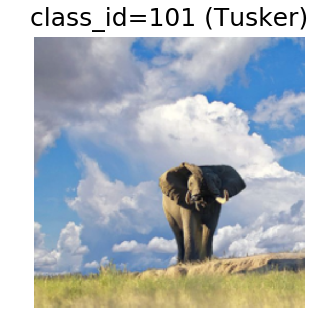

In [4]:
image_path = 'images/elephant.png'
image_class = 101 # tusker
raw_img = viz.pil_loader(image_path)
plt.figure(figsize=(5, 5))
plt.imshow(raw_img)
plt.axis('off')
plt.title('class_id=101 (Tusker)')

In [5]:
all_saliency_maps = []
for model_name, method_name, _ in model_methods:
    transf = get_preprocess(model_name, method_name)
    model = utils.load_model(model_name)
    model.cuda()
    explainer = get_explainer(model, method_name)
    
    inp = transf(raw_img)
    if method_name == 'googlenet':  # swap channel due to caffe weights
        inp_copy = inp.clone()
        inp[0] = inp_copy[2]
        inp[2] = inp_copy[0]
    inp = utils.cuda_var(inp.unsqueeze(0), requires_grad=True)
    
    target = torch.LongTensor([image_class]).cuda()
    saliency = explainer.explain(inp, target)
    saliency = utils.upsample(saliency, (raw_img.height, raw_img.width))
    all_saliency_maps.append(saliency.cpu().numpy())

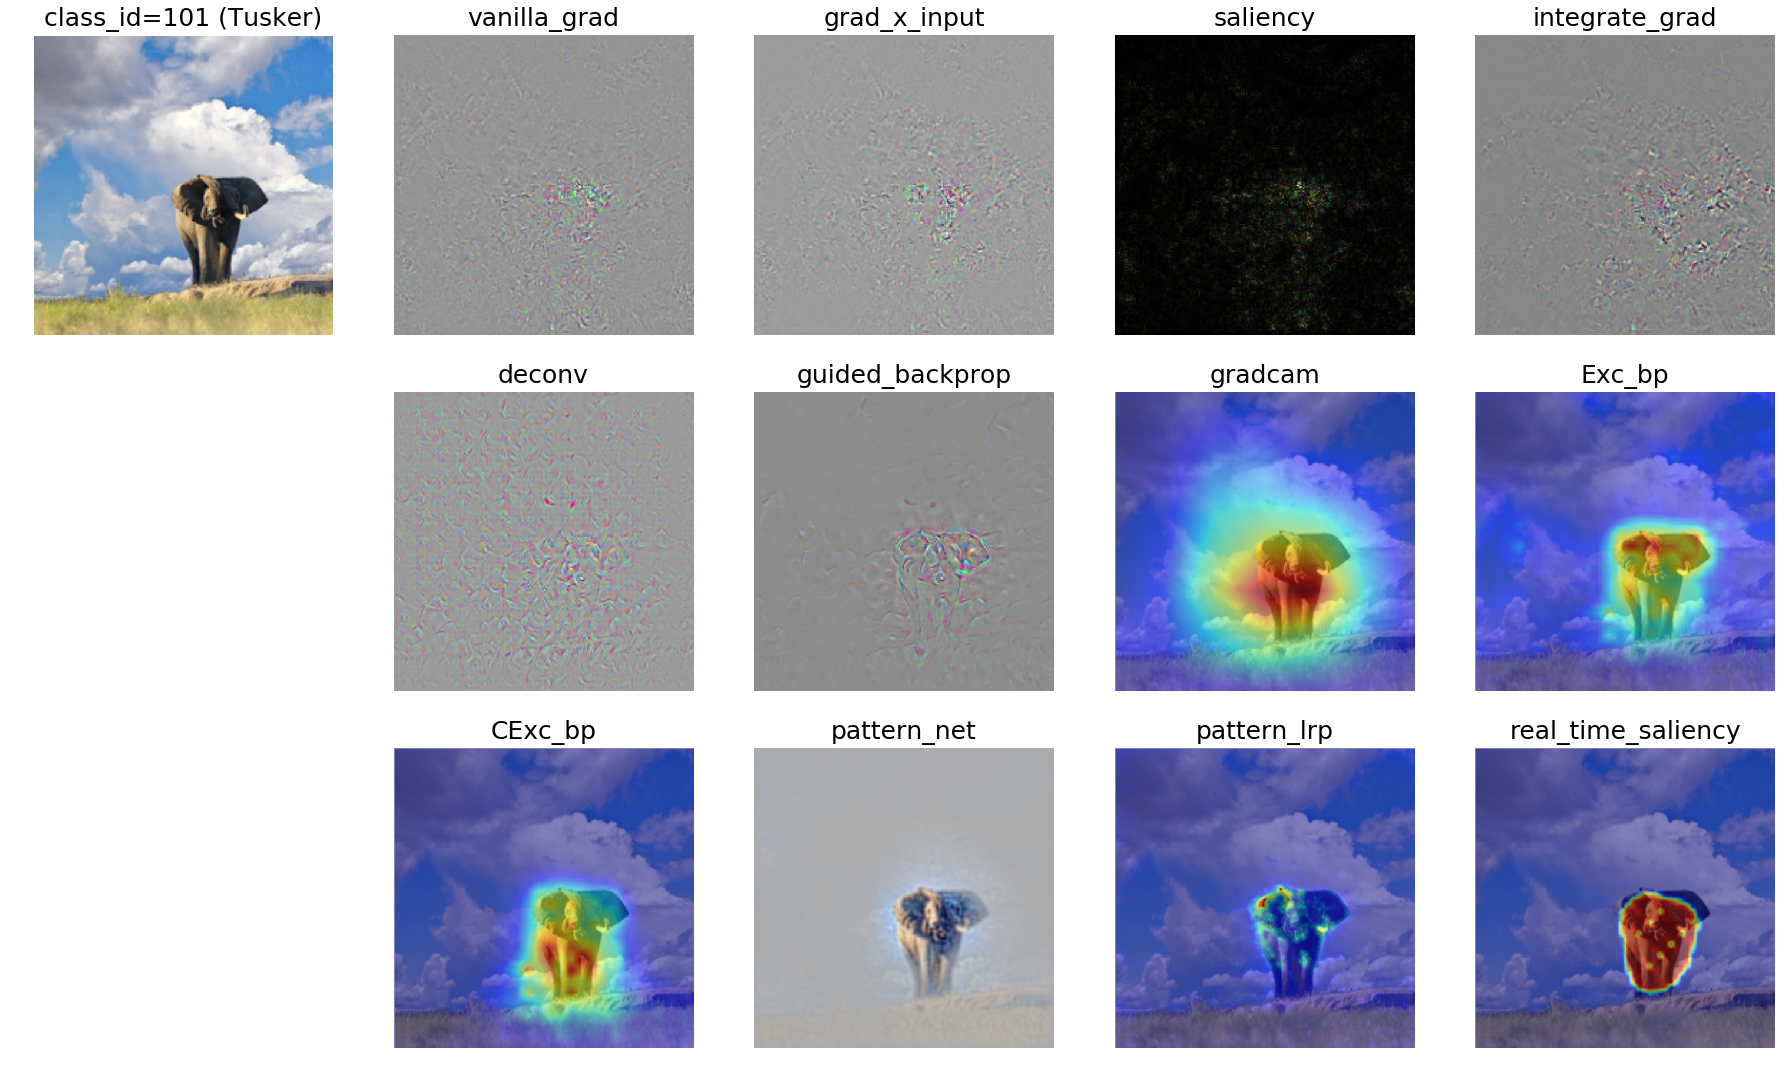

In [6]:
plt.figure(figsize=(25, 15))
plt.subplot(3, 5, 1)
plt.imshow(raw_img)
plt.axis('off')
plt.title('class_id=101 (Tusker)')
for i, (saliency, (model_name, method_name, show_style)) in enumerate(zip(all_saliency_maps, model_methods)):
    plt.subplot(3, 5, i + 2 + i // 4)
    if show_style == 'camshow':
        viz.plot_cam(np.abs(saliency).max(axis=1).squeeze(), raw_img, 'jet', alpha=0.5)
    else:
        if model_name == 'googlenet' or method_name == 'pattern_net':
            saliency = saliency.squeeze()[::-1].transpose(1, 2, 0)
        else:
            saliency = saliency.squeeze().transpose(1, 2, 0)
        saliency -= saliency.min()
        saliency /= (saliency.max() + 1e-20)
        plt.imshow(saliency, cmap='gray')
    
    plt.axis('off')
    if method_name == 'excitation_backprop':
        plt.title('Exc_bp')
    elif method_name == 'contrastive_excitation_backprop':
        plt.title('CExc_bp')
    else:
        plt.title('%s' % (method_name))

plt.tight_layout()
plt.savefig('images/tusker_saliency.png')